# General Idea

Imagine you have a mono signal you want to compress.

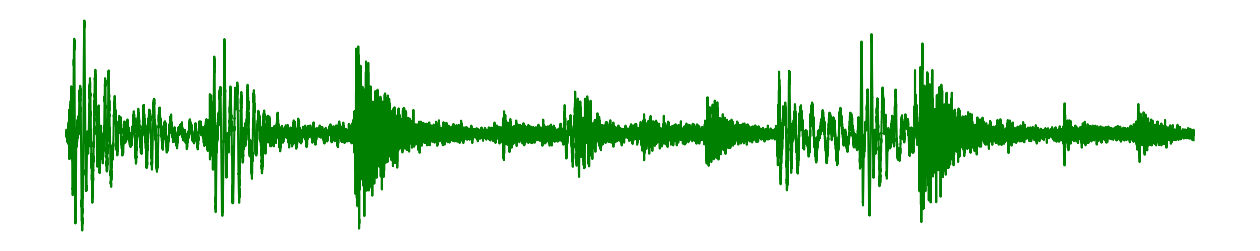</img>

In order to do that, you slice the sample into small, short pieces of a fixed length. In case of longer audio samples, it would be the best if the length of a slice aligns with the BPM. Let us illustrate that process on a fragment of the sample above.

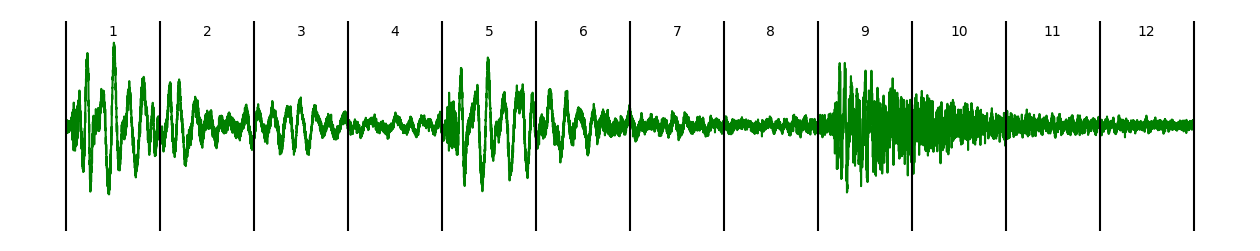</img>

You get a bunch of slices:

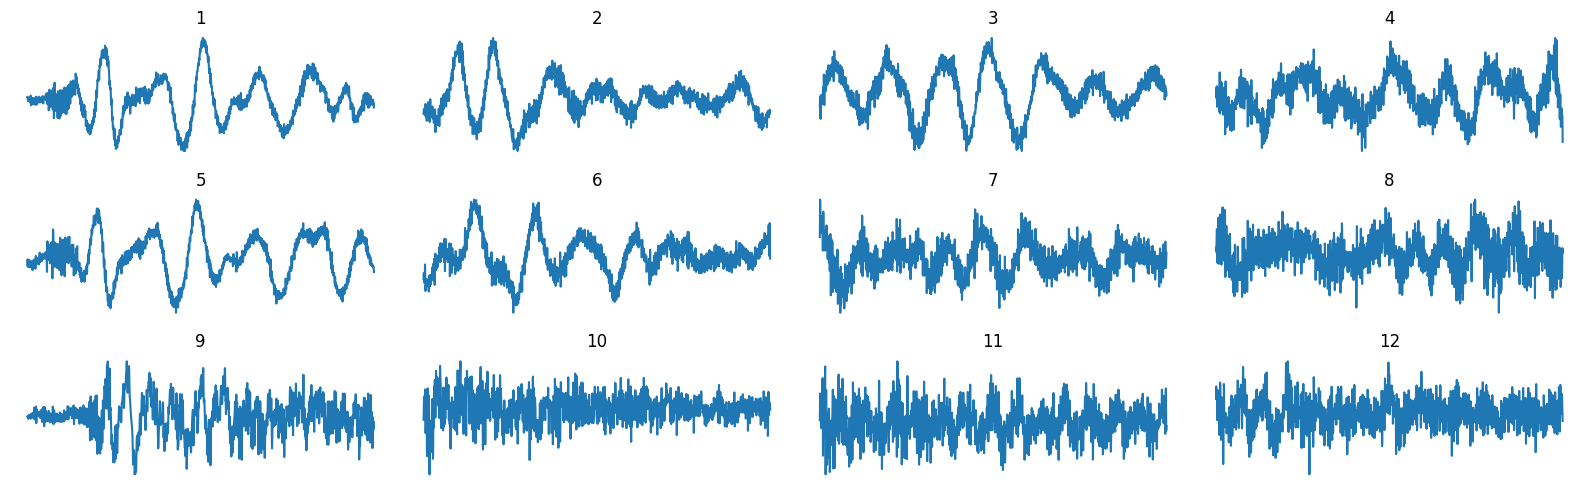</img>

Now, you want to find a *smaller* number of samples that approximate all samples above, let's call it a **basis** of the audio. We are going to represent all samples above using elements only from the basis.

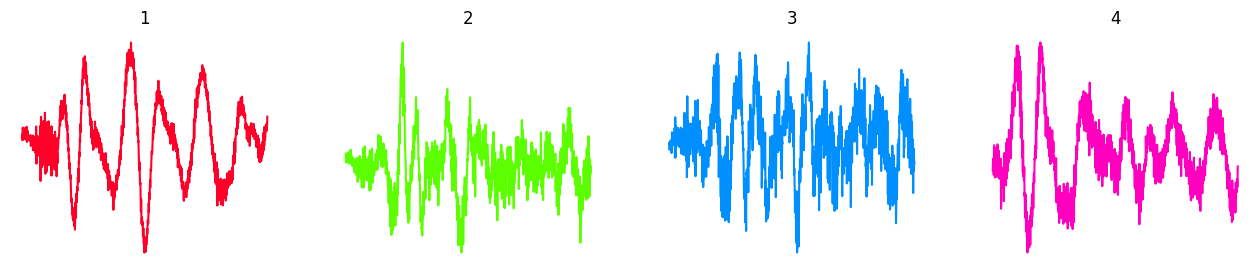</img>

More precisely, by approximation we mean that each original slice is a combination of basis elements, as the image below shows:

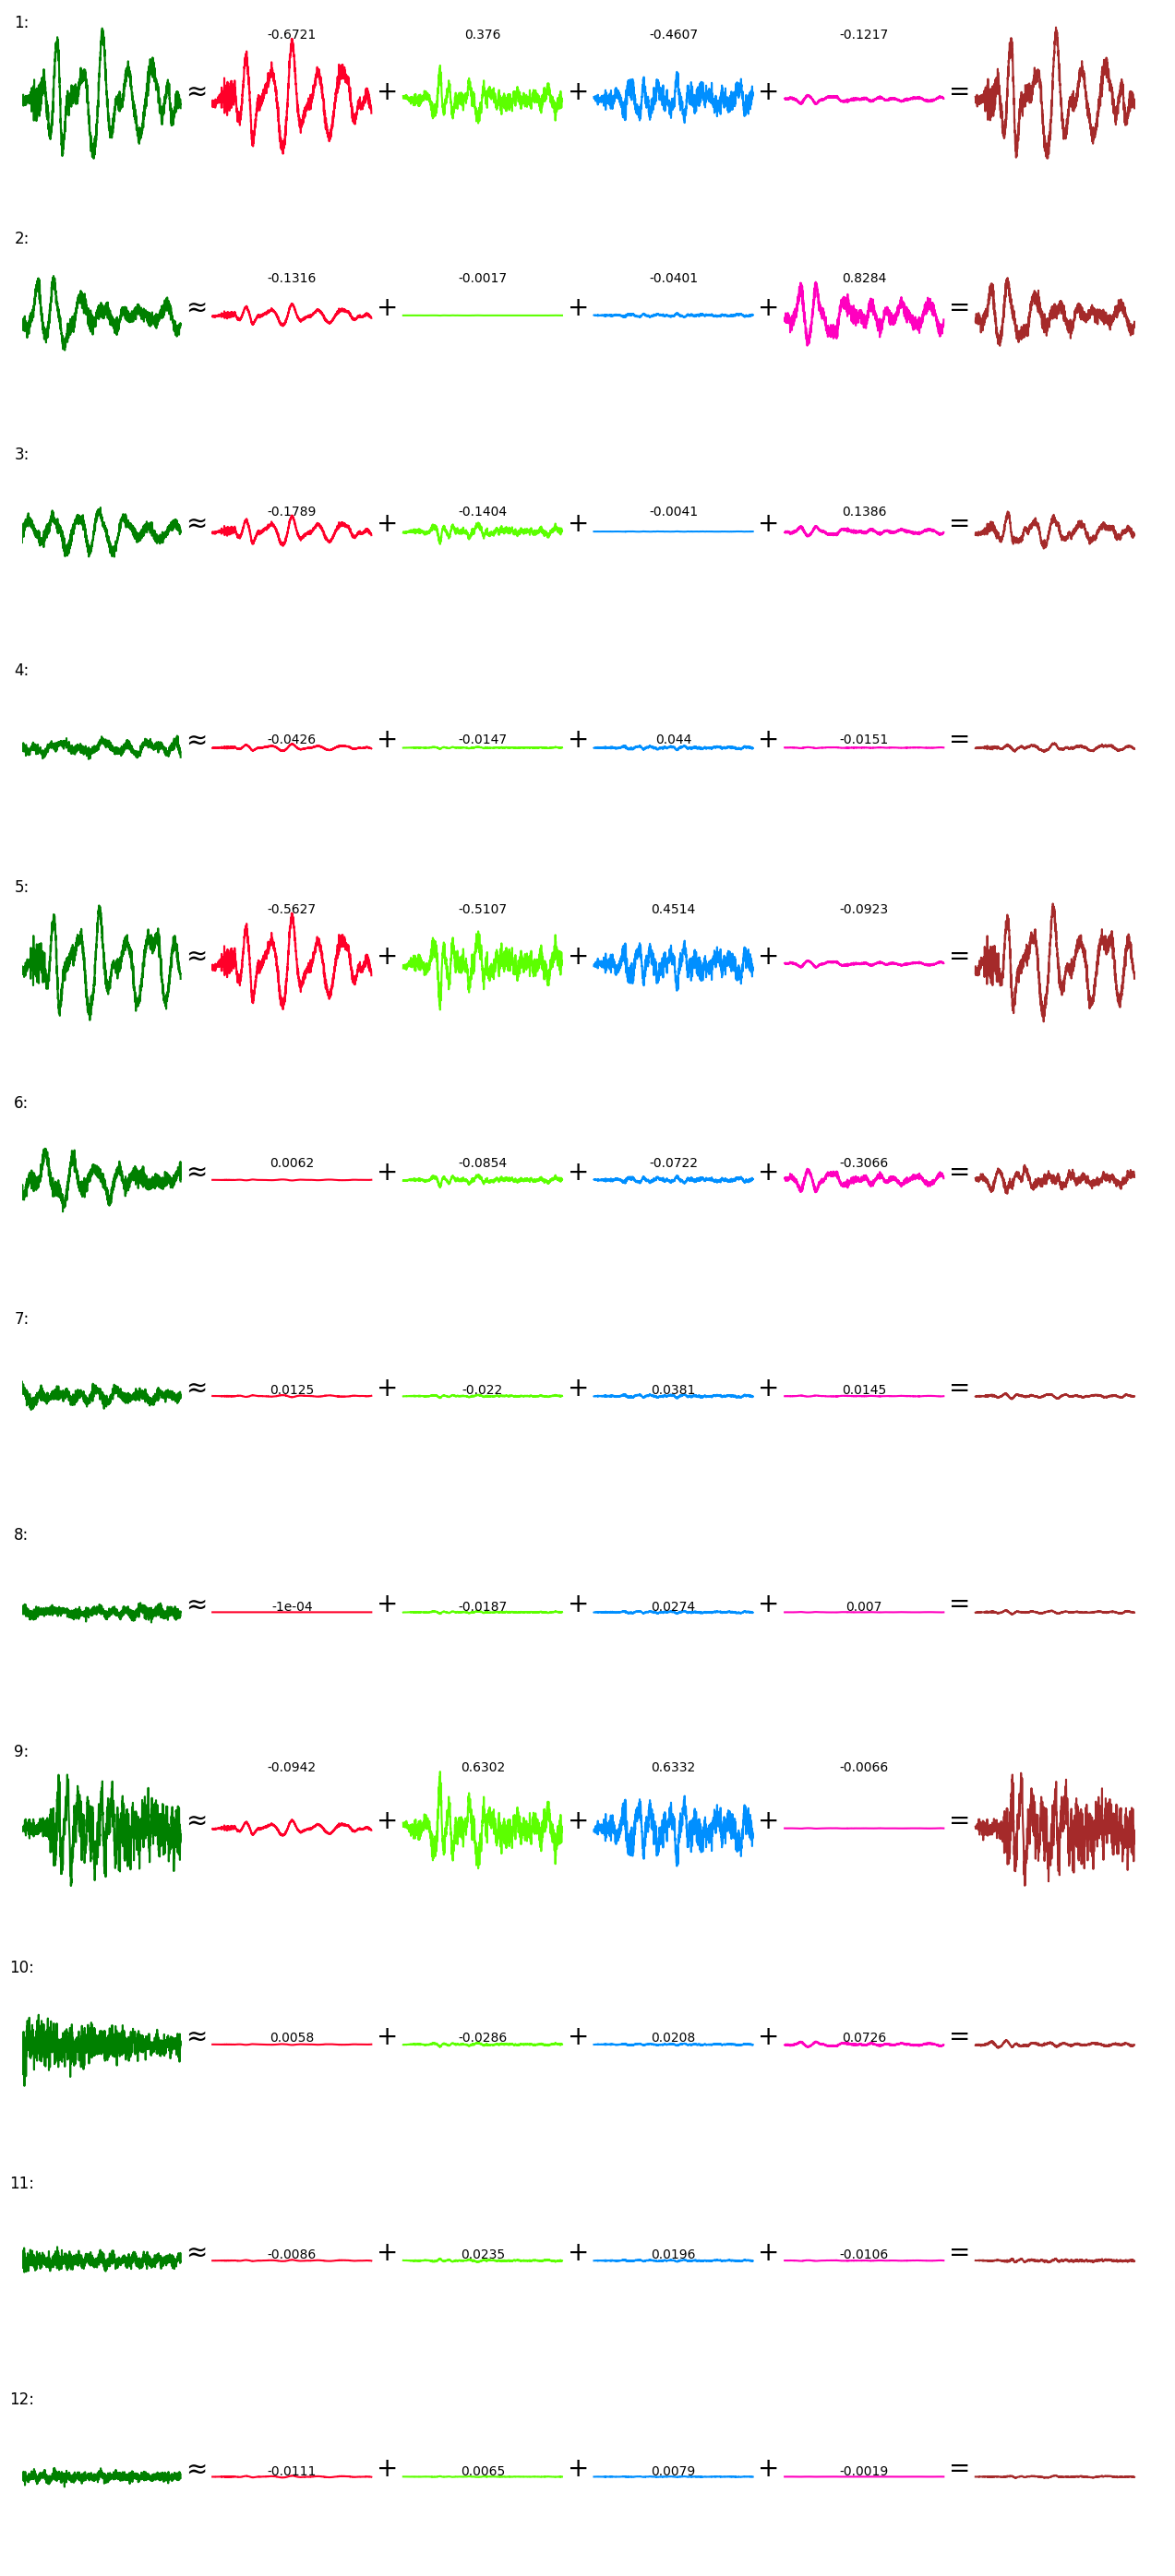</img>

If you have these, you can reassemble your audio by concatenating all calculated samples:

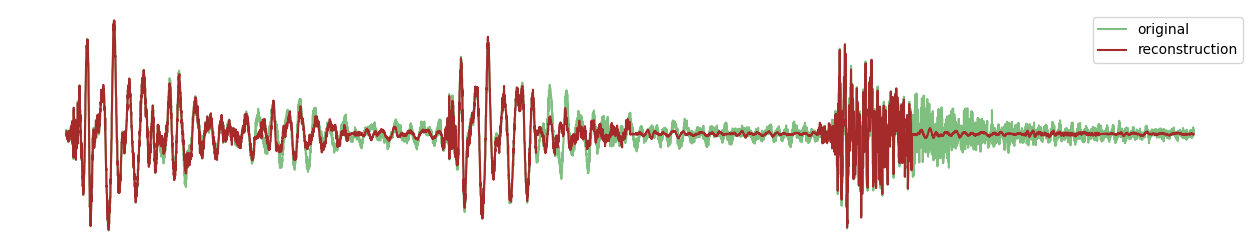</img>

We approximated the original sample using only 4 samples (and the matrix of coefficients). It's not perfect but not bad either.

But how do we get these basic blocks? 

## Singular Value Decomposition

Here comes the math. We use _Singular Value Decomposition_ (SVD) method. We can treat each sample as 1D array of temporal amplitude points:

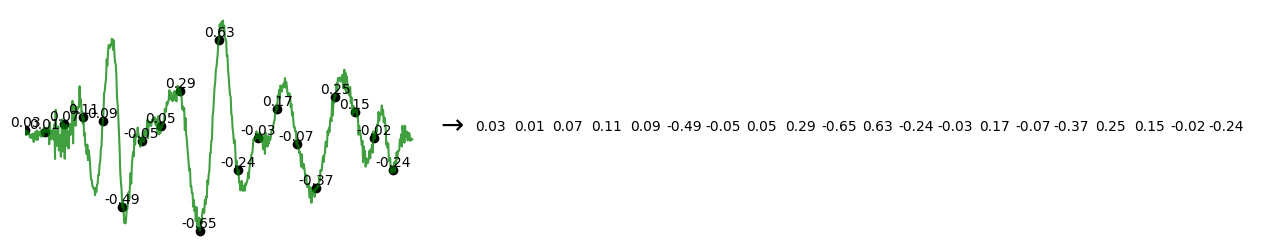</img>

And by combining all the slices we have, we can represent our audio signal as a matrix. Thus, the rows of the matrix are precisely the short 1D arrays of slices we cut in the first place:


$$M = \begin{bmatrix}0.03 &  0.01 & -0.01 &  0.02 &  0. & \ldots \\
-0.1  & -0.08 & -0.13 & -0.08 & -0.09 & \ldots \\
-0.06 & -0.07 & -0.04 & -0.03 & -0.05 & \ldots \\
-0.   &  0.01 & -0.02 &  0.   &  0.   & \ldots \\
\vdots & \vdots & \vdots & \vdots & \vdots & \ddots
\end{bmatrix}$$

The idea of SVD is to decompose a matrix $M$ into a product of three matrices:

$$M = U\Sigma V^T$$

where $U$ and $V$ are orthogonal matrices, and $\Sigma$ is a diagonal matrix. Without going into too much details, SVD decomposes a matrix into principal directions ($U$), and measures how strong the matrix acts on these directions ($\Sigma$). The product $U\Sigma$ describes the most important components of the matrix, that capture the most of the variance of the data.

If we truncate these matrices to only $n$ components, we get a lower-dimensional approximation of the original matrix. And that's it. That's how we find the samples (represented as the truncated matrix $U\Sigma$) with their coefficients ($V^T$).

# Patterns and Samples

After calculating the decomposition $M = U\Sigma V^T$ we truncate it to the first $n$ components, yielding $U_n$, $\Sigma_n$ and $V_n$.

We can recover **samples** from the matrix $(U_n \Sigma_n)^T$. To transfer the reconstruction of the audio sample to the _FastTracker 2_ (or _Impulse Tracker_) module, we need to play each frame with certain coefficients. Each frame can be represented as a single pattern row with as many channels as there are samples. Volumes can be naturally used as coefficients.

After the decomposition and truncation, the samples are normalized and converted to the 16-bit resolution. Similarly, the coefficients are normalized to the supported 6-bit range (from `0x00` to `0x3F`). 

An observant reader may notice that trackers don't support *negative* volumes. The most straightforward (but probably not optimal) solution is to keep copies of samples with inverted phases. If the coefficient is negative, we play the inverted copy with the absolute value of the volume. This gives us a 7-bit volume resolution.

Let us review our example. In our case, the first chunk of the audio has been decomposed into four parts:

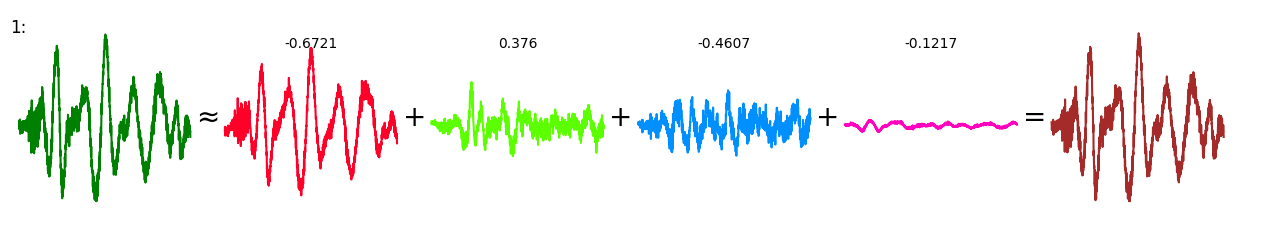</img>

We need to discretize the coefficients into the 7-bit range. Since all coefficients lie in the unit interval $[0, 1]$, this means that each coefficient needs to be multiplied by $64$ and rounded to an integer. Hence, our first row will be composed of four channels with the corresponding values:

$$-0.6721 \cdot 64  \approx -43, \quad 0.376\cdot 64 \approx 24, \quad -0.4607 \approx -29, \quad -0.1217 \cdot 64\approx -8$$

In order to manage inverted samples, we can use the instruments functionality and map the first sample of an instrument to `C-3` note, and the inverted sample to `C#3` (of course playing at the same pitch as the previous note). Then our first row is composed of four channels:

| Channel 1 | Channel 2 | Channel 3 | Channel 4 |
|-|-|-|-|
|`C#3 01 v43 ...`|`C-3 02 v24 ...`|`C#3 01 v29 ...`|`C-3 02 v08 ...`|

Then, we simply continue the process for all subsequent rows, dividing all frames into patterns:

| Channel 1 | Channel 2 | Channel 3 | Channel 4 |
|-|-|-|-|
|`C#3 01 v43 ...`|`C-3 02 v24 ...`|`C#3 03 v29 ...`|`C#3 04 v08 ...`|
|`C#3 01 v08 ...`|`... .. ... ...`|`C#3 03 v03 ...`|`C-3 04 v53 ...`|
|`C#3 01 v11 ...`|`C#3 02 v09 ...`|`... .. ... ...`|`C-3 04 v09 ...`|
|`C#3 01 v03 ...`|`C#3 02 v01 ...`|`C-3 03 v03 ...`|`C#3 04 v01 ...`|
|`C#3 01 v36 ...`|`C#3 02 v33 ...`|`C-3 03 v29 ...`|`C#3 04 v06 ...`|
|`... .. ... ...`|`C#3 02 v05 ...`|`C#3 03 v05 ...`|`C#3 04 v20 ...`|
|`C-3 01 v01 ...`|`C#3 02 v01 ...`|`C-3 03 v02 ...`|`C-3 04 v01 ...`|
|`... .. ... ...`|`C#3 02 v01 ...`|`C-3 03 v02 ...`|`... .. ... ...`|
|`C#3 01 v06 ...`|`C-3 02 v40 ...`|`C-3 03 v41 ...`|`... .. ... ...`|
|`... .. ... ...`|`C#3 02 v02 ...`|`C-3 03 v01 ...`|`C-3 04 v05 ...`|
|`C#3 01 v01 ...`|`C-3 02 v02 ...`|`C-3 03 v01 ...`|`C#3 04 v01 ...`|
|`C#3 01 v01 ...`|`... .. ... ...`|`C-3 03 v01 ...`|`... .. ... ...`|

# Limitations

There are severe limitations of this procedure:

* The 7-bit volume resolution introduces quantization noise.
* The number of channels is limited to 32 in _FastTracker 2_ and 64 in _Impulse Tracker_.
* The number of instruments is limited to 255.

## Quantization Noise

Rounding the values to integers significantly affects the audio reconstruction quality, especially for small coefficients. These errors lead to **quantization noise**, which distorts the original signal. Small coefficients vanish completely. 

To improve the volume resolution, we can sacrifice some of the 16-bit depth resolution of the samples. We create a quieter version of each sample (including inverted ones) and play that copy each time the volume is in the low range (e.g. less than $8$). This approach doubles the size of the samples but enhances the reconstruction quality.

In our example, we can assign quiet versions to subsequent notes `D-3` and `D#3`, for each instrument.  

| Channel 1 | Channel 2 | Channel 3 | Channel 4 |
|-|-|-|-|
|`C#3 01 v43 ...`|`C-3 02 v24 ...`|`C#3 03 v29 ...`|`D#3 04 v62 ...`|
|`C#3 01 v08 ...`|`... .. ... ...`|`D#3 03 v20 ...`|`C-3 04 v53 ...`|
|`C#3 01 v11 ...`|`C#3 02 v08 ...`|`D#3 03 v02 ...`|`C-3 04 v08 ...`|
|`D#3 01 v21 ...`|`D#3 02 v07 ...`|`D-3 03 v22 ...`|`D#3 04 v07 ...`|
|`C#3 01 v36 ...`|`C#3 02 v32 ...`|`C-3 03 v28 ...`|`D#3 04 v47 ...`|
|`D-3 01 v03 ...`|`D#3 02 v43 ...`|`D#3 03 v36 ...`|`C#3 04 v19 ...`|
|`D-3 01 v06 ...`|`D#3 02 v11 ...`|`D-3 03 v19 ...`|`D-3 04 v07 ...`|
|`... .. ... ...`|`D#3 02 v09 ...`|`D-3 03 v14 ...`|`D-3 04 v03 ...`|
|`D#3 01 v48 ...`|`C-3 02 v40 ...`|`C-3 03 v40 ...`|`D#3 04 v03 ...`|
|`D-3 01 v02 ...`|`D#3 02 v14 ...`|`D-3 03 v10 ...`|`D-3 04 v37 ...`|
|`D#3 01 v04 ...`|`D-3 02 v12 ...`|`D-3 03 v10 ...`|`D#3 04 v05 ...`|
|`D#3 01 v05 ...`|`D-3 02 v03 ...`|`D-3 03 v04 ...`|`... .. ... ...`|

## Limited Number of Channels

Even for short audio samples, 32 channels (which limit the number of actual samples to 32) are not enough to represent the audio faithfully. If we need more samples, we must choose only a fraction that can be played simultaneously.

To overcome that, we can sort all samples by energy, and at each frame, pick only the first $n$ ones. This way, we lose only the weaker components, preserving the most essential parts of the reconstruction.

## Limited Number of Instruments

The number of instruments is limited in both trackers. Even if we decide to truncate the number of channels, we still need to handle this limitation.

FastTracker 2 allows combining several samples into one instrument. Since 16 is the maximum number of samples per instrument, and each sample takes up 4 slots, we can effectively pack only 4 different samples, excluding the inverted and quieter variants. Unfortunately, _Impulse Tracker_ does not allow such tricks, but using OpenMPT hacks we can keep more than 255 samples.

However, we cannot have more samples than the length of a sample! The default sample size is set to 441.

## Sample Phase

The most annoying obstacle seems rather technical at the first glance but hurts the audio quality in the most inevitable way.

Each sample is represented as a waveform. However, what makes a sound is not the absolute amplitude but the change between consecutive amplitude values. Theoretically, these two waveform should produce the same sound:

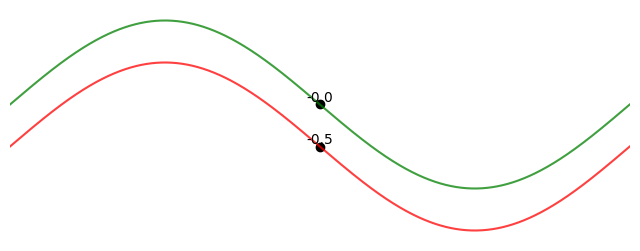</img>

Except they don't. The reason behind that that each sample is being played starting with the zero position. So, the red sample actually starts with a "tick" which becomes audible.

The same goes with the end of the sample: each played sample is going to reset to the zero position. If samples don't start and end with zero, they are going to produce audible ticks.

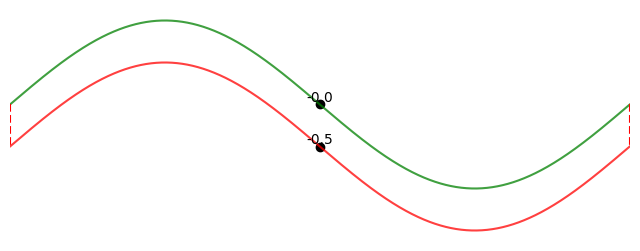</img>

The _Singular Value Decomposition_ does not produce samples that start and end at the zero position. This is actually a feature: such characteristic actually helps encode information about frequencies below the frequency of a sample (determined by the sample length). For a sample size of 441, these ticks have their own frequency: 100 Hz (since 44100 is the sampling frequency).

We can remove the sample offset using a simple transformation; however, such operations introduce a bias at a certain frequency. Unfortunately, this is unavoidable due to the playback routine of trackers.